In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time


from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
from tensorflow.python.client import device_lib


print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9412119498244406961
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3044750132
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17412464590988283330
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [5]:
# char_list:'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# total number of our output classes: 63
char_list = string.ascii_letters+string.digits
 
def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [6]:
path = 'C:/Users/Adarsh/Desktop/Work/4th year/8th sem/dataset/'
 
 
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0
 
i =1 
flag = 0
 
for root, dirnames, filenames in os.walk(path):
 
    for f_name in fnmatch.filter(filenames, '*.jpg'):
        
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   
 
       
        w, h = img.shape
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))
 
        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        
        
        img = img/255.
        
        
        txt = f_name.split('_')[1]
        
      
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
        

        if i == 150000:
            flag = 1
            break
        i+=1
    if flag == 1:
        break

In [7]:
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [8]:
 
inputs = Input(shape=(32,128,1))
 

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 

blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

act_model = Model(inputs, outputs)

In [9]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

In [10]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])


model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [11]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['acc'])
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [12]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [13]:
batch_size = 256
epochs = 40
history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length],
                    y=np.zeros(len(training_img)),
                    batch_size=batch_size, 
                    epochs = epochs,
                    validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length],
                                       [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/40
357/357 [==============================] - 219s 555ms/step - loss: 30.1465 - acc: 0.0000e+00 - val_loss: 28.7756 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 28.77564, saving model to best_model.hdf5
Epoch 2/40
357/357 [==============================] - 233s 653ms/step - loss: 25.4190 - acc: 0.0000e+00 - val_loss: 24.1078 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 28.77564 to 24.10781, saving model to best_model.hdf5
Epoch 3/40
357/357 [==============================] - 219s 613ms/step - loss: 20.5572 - acc: 1.7977e-05 - val_loss: 14.3050 - val_acc: 9.8542e-05

Epoch 00003: val_loss improved from 24.10781 to 14.30498, saving model to best_model.hdf5
Epoch 4/40
357/357 [==============================] - 208s 583ms/step - loss: 7.3897 - acc: 0.0790 - val_loss: 5.0434 - val_acc: 0.3166

Epoch 00004: val_loss improved from 14.30498 to 5.04340, saving model to best_model.hdf5
Epoch 5/40
357/357 [==============================] - 212s 595ms/ste

In [14]:
import matplotlib.pyplot as plt
def display(x,y):

  
  act_model.load_weights('best_model.hdf5')
  prediction = act_model.predict(x.reshape(1,32,128,1))

  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  x = x.reshape(32,128)
  plt.title('Input Image')
  plt.imshow(x)
  plt.axis('off')
  plt.show()


  for x in out:
      print("predicted text = ", end = '')
      for p in x:  
          if int(p) != -1:
              print(char_list[int(p)], end = '')       
      print('\n')

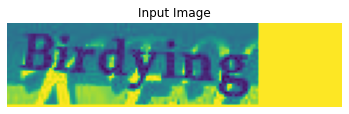

predicted text = Birdying



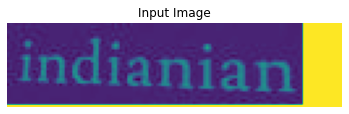

predicted text = indianian



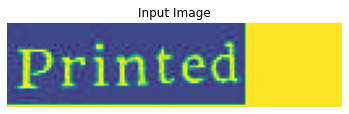

predicted text = Printed



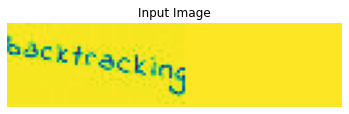

predicted text = bocetracting



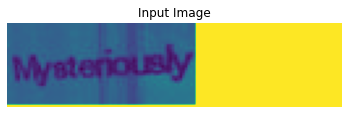

predicted text = Myaterously



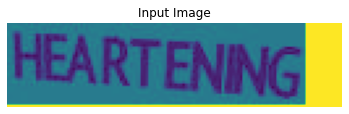

predicted text = HEARTENING



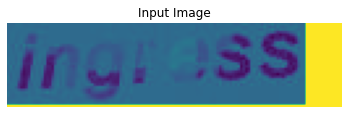

predicted text = ingress



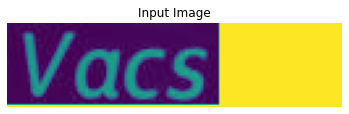

predicted text = Vacs



In [25]:
for i in range(8):
  i = np.random.randint(91338)
  display(training_img[i],train_padded_txt[i])

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


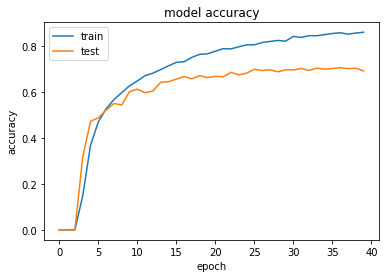

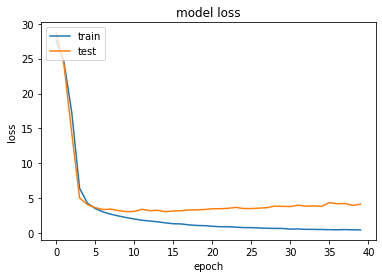

In [16]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()